# Exercise 1: Multiple independent time series

[Forecasting for machine learning](https://www.trainindata.com/p/forecasting-with-machine-learning)


In this notebook we have an exercise to do multiple independent time series forecasting. The solutions we show are only one way of answering these questions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data preparation

The dataset we shall use is the Quarterly overnight trips (in thousands) from 1998 Q1 to 2016 Q4 across
Australia. The number of trips is split by `State`, `Region`, and `Purpose`. 

**In this exercise we are going to forecast the total number of trips for each Region (there are 76 regions therefore we will have 76 time series). We shall treat this as a multiple independent time series forecasting problem.**

Source: A new tidy data structure to support
exploration and modeling of temporal data, Journal of Computational and
Graphical Statistics, 29:3, 466-478, doi:10.1080/10618600.2019.1695624.
Shape of the dataset: (24320, 5)

In [2]:
from skforecast.datasets import fetch_dataset

# Load the data
data = fetch_dataset(name="australia_tourism", raw=True)
data.head()

australia_tourism
-----------------
Quarterly overnight trips (in thousands) from 1998 Q1 to 2016 Q4 across
Australia. The tourism regions are formed through the aggregation of Statistical
Local Areas (SLAs) which are defined by the various State and Territory tourism
authorities according to their research and marketing needs.
Wang, E, D Cook, and RJ Hyndman (2020). A new tidy data structure to support
exploration and modeling of temporal data, Journal of Computational and
Graphical Statistics, 29:3, 466-478, doi:10.1080/10618600.2019.1695624.
Shape of the dataset: (24320, 5)


,date_time,Region,State,Purpose,Trips
0,1998-01-01,Adelaide,South Australia,Business,135.077690
1,1998-04-01,Adelaide,South Australia,Business,109.987316
2,1998-07-01,Adelaide,South Australia,Business,166.034687
3,1998-10-01,Adelaide,South Australia,Business,127.160464
4,1999-01-01,Adelaide,South Australia,Business,137.448533


Pre-process the data by performing the following:
1) Convert the `date_time` column to datetime type
2) Create a dataframe with one column per `Region` which gives the total number of Trips for each date.
3) Ensure the index is `date_time` and resampled to quarterly start `QS`


In [3]:
data["date_time"] = pd.to_datetime(data["date_time"])
data = data.groupby(["date_time", "Region"])["Trips"].sum().unstack()
data = data.asfreq("QS")
data.head()

Region,Adelaide,Adelaide Hills,Alice Springs,Australia's Coral Coast,Australia's Golden Outback,Australia's North West,Australia's South West,Ballarat,Barkly,Barossa,...,Sunshine Coast,Sydney,The Murray,Tropical North Queensland,Upper Yarra,Western Grampians,Whitsundays,Wilderness West,Wimmera,Yorke Peninsula
date_time,,,,,,,,,,,,,,,,,,,,,
1998-01-01,658.553895,9.798630,20.207638,132.516409,161.726948,120.775450,474.858729,182.239341,18.465206,46.796083,...,742.602299,2288.955629,356.500087,220.915346,102.791022,86.996591,60.226649,63.335097,18.804743,160.681637
1998-04-01,449.853935,26.066952,56.356223,172.615378,164.973780,158.404387,411.622281,137.566539,7.510969,49.428717,...,609.883333,1814.459480,312.291189,253.097616,74.855136,84.939977,106.190848,42.607076,52.482311,104.324252
1998-07-01,592.904597,26.491072,110.918441,173.904335,206.879934,184.619035,360.039657,117.642761,43.565625,29.743302,...,615.306331,1989.731939,376.718698,423.506735,59.465405,79.974884,81.771005,18.851214,35.657551,68.996468
1998-10-01,524.242760,27.256859,40.868270,207.002571,198.509591,138.878263,462.620050,136.072724,29.359239,78.193066,...,684.430239,2150.913627,336.367694,283.694451,35.238855,116.235617,105.600143,50.450965,27.204455,103.340264
1999-01-01,548.394105,13.772975,48.368038,198.856638,140.213443,103.337122,562.974629,156.456242,6.341997,35.277910,...,842.167418,1779.286905,323.418472,194.509904,67.823457,101.765635,111.504972,59.888003,50.219851,146.658290


Check for missing values.

In [4]:
data.isnull().any().sum()

0

Later we may want to use LightGBM, it does not support special JSON characters (e.g., `'`)  in the column name. Let's remove these characters from the column names.

In [5]:
import re

data = data.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

Assign the name of each state to a variable `Region`. We will use this later.

In [6]:
regions = data.columns

# Exploratory data analysis

Print the number of data points in the time series, the start time, and the end time of the time series.

In [7]:
print(len(data))
print(f"start: {data.index.min()}, end: {data.index.max()}")

80
start: 1998-01-01 00:00:00, end: 2017-10-01 00:00:00


Plot the time series summed over all states.

Text(0.5, 1.0, 'Quartely trips (thousands) - Total')

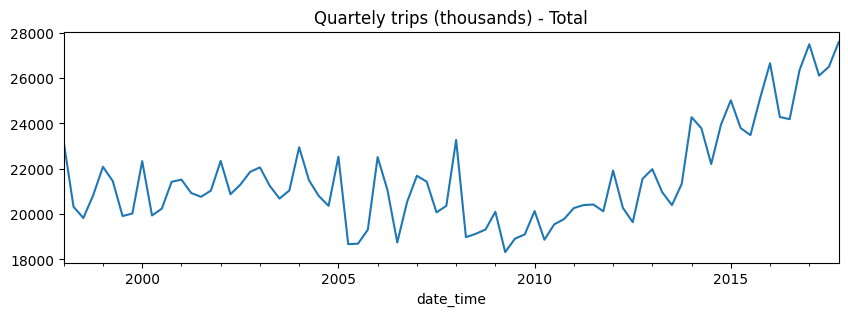

In [8]:
fig, ax = plt.subplots(figsize=[10, 3])
data.sum(axis=1).plot(ax=ax)
ax.set_title("Quartely trips (thousands) - Total")

Plot a subsample of the time series from different regions.

Text(0.5, 1.0, 'Quartely trips (thousands)')

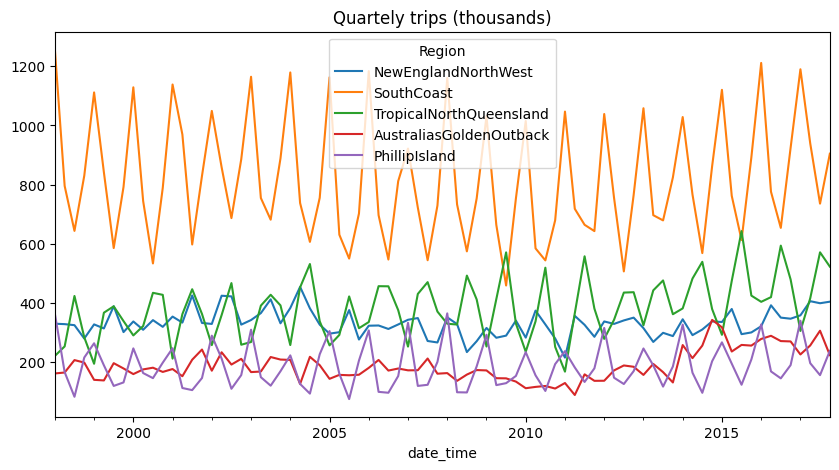

In [9]:
fig, ax = plt.subplots(figsize=[10, 5])
data.sample(n=5, axis=1, random_state=123).plot(ax=ax)
ax.set_title("Quartely trips (thousands)")

It appears that there is yearly seasonality for these series and they appear to be anti-correlated (i.e., some areas experience peaks whilst others experience troughs).

Create a quarter of the year feature which could help with the yearly seasonality.

In [10]:
data["quarter"] = data.index.quarter

# Forecasting

Import the class needed for recursive forecasting for multiple independent time series that allows us to create custom predictors from `skforecast`

In [11]:
from skforecast.ForecasterAutoregMultiSeriesCustom import (
    ForecasterAutoregMultiSeriesCustom,
)

Import a transformer from `sklearn` to scale the data.

In [12]:
# Preprocessing and features
from sklearn.preprocessing import StandardScaler

Import a model of your choice.

In [13]:
# Traditional machine learning models
from lightgbm import LGBMRegressor

Assign the names of the states to a `target_cols` variable and any exogenous features to an `exog_cols` variable.

In [14]:
# Target time series column names
target_cols = regions

# Exogenous feature column names
exog_cols = ["quarter"]

Specify a forecast horizon and assign it to a variable `steps`. Try forecasting 8 quarters into the future.

In [15]:
# Forecast horizon: Number of steps to predict
steps = 8

Create a dataframe for the future values of any exogenous features.

Hint: `pd.DateOffset` and using `freq=QS` in `pd.date_range` might be helpful 

In [16]:
# Prepare exogenous features for the future
future_start_date = data.index.max() + pd.DateOffset(months=3)
future_dates = pd.date_range(start=future_start_date, freq="QS", periods=steps + 1)

future_exog = pd.DataFrame(index=future_dates)
future_exog["quarter"] = future_exog.index.quarter

Define a function to create lag and window features. Try a lag of 8 (2 years of data) and a window of 4 and 8 (1 and 2 years).

In [17]:
# Define a function to extract lag and window features
# See: https://joaquinamatrodrigo.github.io/skforecast/0.11.0/user_guides/custom-predictors.html
def create_predictors(y):
    """
    Create first 7 lags of a time series.
    Calculate rolling mean and standard deviation with window 7 and 30.
    """

    lags = y[-1:-8:-1]  # window_size = 8
    mean_4 = np.mean(y[-4:])  # window_size = 4
    std_4 = np.std(y[-4:])
    mean_8 = np.mean(y[-8:])  # window_size = 8
    std_8 = np.std(y[-8:])

    predictors = np.hstack([lags, mean_4, std_4, mean_8, std_8])

    return predictors


name_predictors = [f"lag_{i}" for i in range(1, 8)] + [
    "mean_4",
    "std_4",
    "mean_8",
    "std_8",
]
name_predictors

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'mean_4',
 'std_4',
 'mean_8',
 'std_8']

Define a weight function (a function of the time axis) that linearly decreases the weight from 1 to 0 as we go back in time. This will give more weight to recent dates. Define it so there are no harded coded dates in the function.

Hint: Consider using `np.linspace`

In [18]:
def custom_weights(index):
    """
    Linearly decrease the weight going back in time.
    """
    num_time_points = len(index)
    weights = np.linspace(start=0, stop=1, num=num_time_points)
    return weights

Define a forecaster to predict all the time series. Pass your weight function and custom predictors function to the forecaster.

In [19]:
# Create LightGBM forecaster
params_lgbm = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 10,
    "random_state": 123,
    "verbose": -1,
}

forecaster = ForecasterAutoregMultiSeriesCustom(
    regressor=LGBMRegressor(**params_lgbm),
    fun_predictors=create_predictors,
    name_predictors=name_predictors,
    window_size=8,  # Largest window size needed
    # by `create_predictors`
    weight_func=custom_weights,
    transformer_series=StandardScaler(),
    transformer_exog=StandardScaler(),
)

forecaster

ForecasterAutoregMultiSeriesCustom 
Regressor: LGBMRegressor(max_depth=10, random_state=123, verbose=-1) 
Predictors created with function: create_predictors 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 8 
Series levels (names): None 
Series weights: None 
Weight function included: True 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None, 'random_state': 123, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2

Fit the forecaster.

In [20]:
# Target time series column names
target_cols = regions

# Exogenous feature column names
exog_cols = ["quarter"]

forecaster.fit(
    series=data[target_cols],  # Dataframe of target time series at train time
    exog=data[exog_cols],  # Dataframe of exogenous variables at train time
)

forecaster

ForecasterAutoregMultiSeriesCustom 
Regressor: LGBMRegressor(max_depth=10, random_state=123, verbose=-1) 
Predictors created with function: create_predictors 
Transformer for series: StandardScaler() 
Transformer for exog: StandardScaler() 
Window size: 8 
Series levels (names): ['Adelaide', 'AdelaideHills', 'AliceSprings', 'AustraliasCoralCoast', 'AustraliasGoldenOutback', 'AustraliasNorthWest', 'AustraliasSouthWest', 'Ballarat', 'Barkly', 'Barossa', 'BendigoLoddon', 'BlueMountains', 'Brisbane', 'Bundaberg', 'Canberra', 'CapitalCountry', 'CentralCoast', 'CentralHighlands', 'CentralMurray', 'CentralNSW', 'CentralQueensland', 'ClareValley', 'DarlingDowns', 'Darwin', 'EastCoast', 'ExperiencePerth', 'EyrePeninsula', 'FleurieuPeninsula', 'FlindersRangesandOutback', 'FraserCoast', 'GeelongandtheBellarine', 'Gippsland', 'GoldCoast', 'Goulburn', 'GreatOceanRoad', 'HighCountry', 'HobartandtheSouth', 'Hunter', 'KakaduArnhem', 'KangarooIsland', 'KatherineDaly', 'Lakes', 'Lasseter', 'LauncestonTa

Make a forecast.

In [21]:
forecast = forecaster.predict(
    steps=steps,
    exog=future_exog,
)

Plot the a random subset of the time series and the forecast.

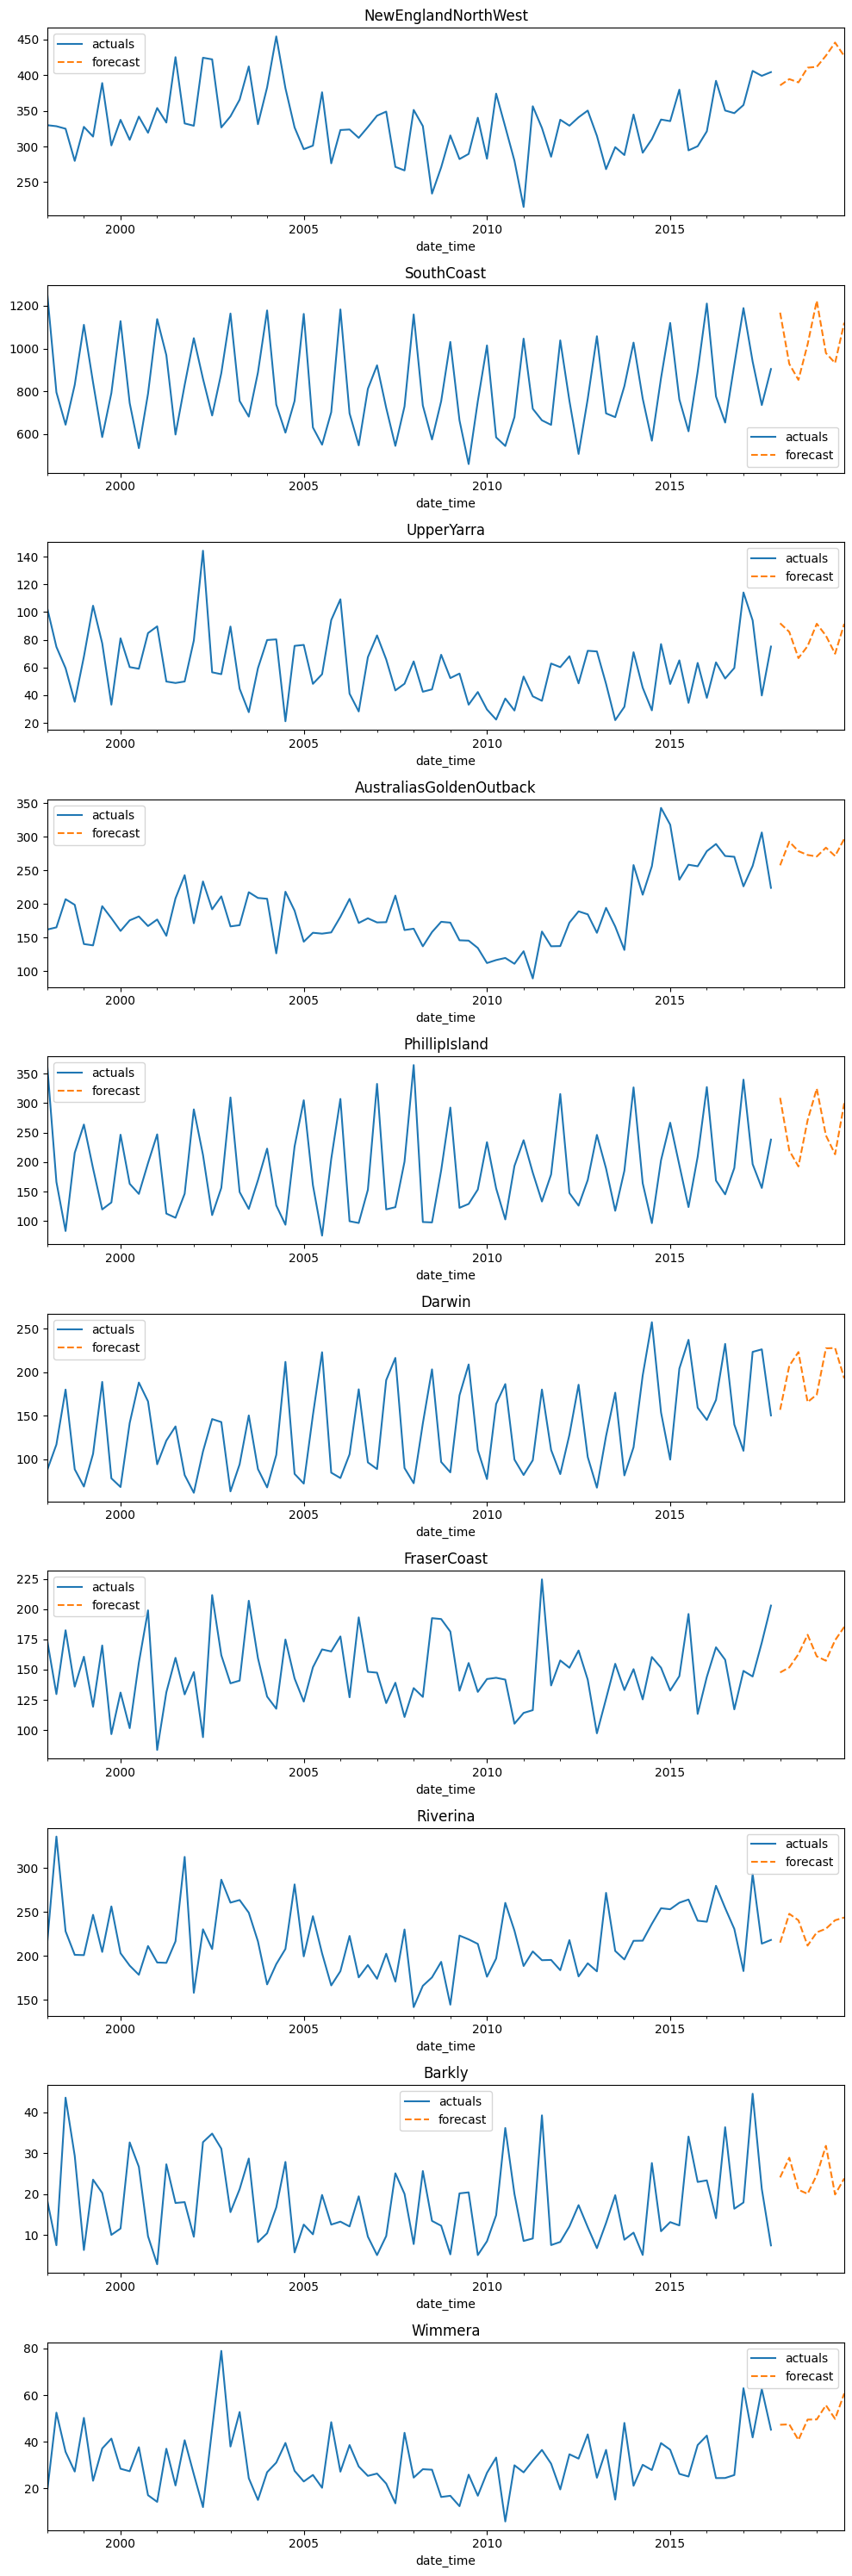

In [22]:
# Select a random subsample of timeseries
num_timeseries = 10
data_subset = data.sample(n=num_timeseries, axis=1, random_state=123)

# Plotting
fig, axs = plt.subplots(nrows=num_timeseries, figsize=[10, 3 * num_timeseries])
for ix in range(num_timeseries):
    region = data_subset.columns[ix]
    ax = axs[ix]
    data_subset.loc[:, region].plot(ax=ax, label="actuals")
    forecast.loc[:, region].plot(ax=ax, linestyle="--", label="forecast")
    ax.legend()
    ax.set_title(f"{region}")
plt.tight_layout()

# Feature importance

Plot the 10 most important features.

<Axes: xlabel='feature'>

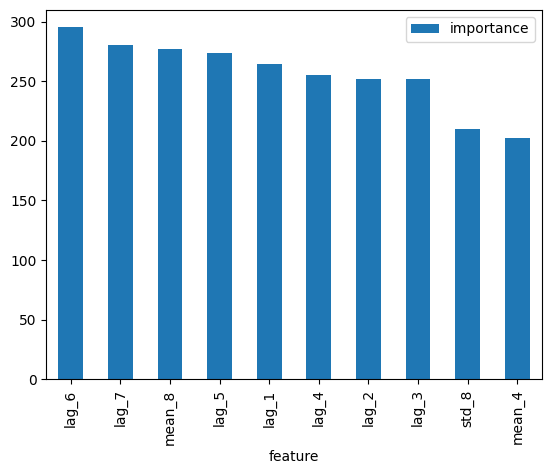

In [23]:
# Plot feature importance
(
    forecaster.get_feature_importances()
    .assign(importance=lambda df: np.abs(df.importance))
    .nlargest(n=10, columns=["importance"])
    .set_index("feature")
).plot(kind="bar")